# General imports

In [39]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import os

# Upload the dataset

In [ ]:
!unzip fec_2013.zip

In [6]:
train_data_dir='fec_2013/train'
validation_data_dir='fec_2013/test'

## Dataset 'fer2013' which is an open source dataset hosted on kaggle and specially prepeared for emotion recognition

In [18]:
num_classes = 7
img_shape = (48, 48)
batch_size = 32

#### The discription for above variables are as follows:
#### num_classses = 5 : This variable defines the number of classes or the emotions that we will be dealing with in training our model.
#### img_rows,img_cols=48,48 : These variables define the size of the image array that we will be feeding to our neural network.
#### batch_size=32: This variable defines the batch size.The batch size is a number of samples processed before the model is updated. The number of epochs is the number of complete passes through the training dataset. The size of a batch must be more than or equal to one and less than or equal to the number of samples in the training dataset.

In [19]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=30,
                shear_range=0.3,
                zoom_range=0.3,
                width_shift_range=0.4,
                height_shift_range=0.4,
                horizontal_flip=True,
                fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

#### The train_datagen variable will artificially expand the dataset using the following:
#### rotation_range: Degree range for random rotations. Here we decide to use 30 degrees.
#### shear_range: Shear Intensity (Shear angle in counter-clockwise direction in degrees). Herewe decide to use 0.3 as shear range.
#### zoom_range: Range for random zoom.Herewe decide to use 0.3 as zoom range.
#### width_shift_range: This shifts the images by a value across its width.
#### height_shift_range : This shifts the images by a value across its height.
#### horizontal_flip: This flips the images horizontally.
#### fill_mode: This is used to fill in the pixels after making changes to the orientation of the images by the above used methods. Here we decide to use ‘nearest’ as the fill mode as we instruct it to fill the missing pixels in the image with the nearby pixels.

In [61]:
train_generator = train_datagen.flow_from_directory(
                                    train_data_dir,
                                    color_mode='grayscale',
                                    target_size=(img_rows,img_cols),
                                    batch_size=batch_size,
                                    class_mode='categorical',
                                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
                                validation_data_dir,
                                color_mode='grayscale',
                                target_size=(img_rows,img_cols),
                                batch_size=batch_size,
                                class_mode='categorical',
                                shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


#### Here we just resclaing the validation data and not performing any other augmentaions as we want to check the model with raw data that is different from the data used in the training of the model.
#### The dataset contains totally 7 classes namely Angry,Disgust,Fear,Happy,Sad,Surprise and Neutral. The training set consists of a total of 28,709 examples.
#### As we mentioned in our presentation we use only 5 classes: Angry,Happy,Sad,Surprise and Neutral
#### The options given are:
#### directory: The directory of the dataset.
#### color_mode: Here we convert the images to gray-scale as i am not interested in the color of the images but only the expressions.
#### target_size: Convert the images to a uniform size.
#### batch_size: To make baches of data to train.
#### class_mode: Her we use ‘categorical’ as the class mode as i am categorizing my images into 5 classes.
#### shuffle: To shuffle the dataset for better training.

In [21]:
model = Sequential()

#### Here we use a Sequential model which defines that all the layers in the network will be one after the other sequentially and storing it in a variable model.

In [22]:
# Block 1
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_shape[0],img_shape[1],1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_shape[0],img_shape[1],1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 2
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 3
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 4
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 5
model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# Block 6
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# Block 7
model.add(Dense(num_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
activation_11 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_12 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)       

In [31]:
checkpoint = ModelCheckpoint('EmotionDetectionModel.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [checkpoint, reduce_lr]

In [32]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

nb_train_samples = 28709
nb_validation_samples = 7178
epochs = 50

history = model.fit_generator(
                train_generator,
                steps_per_epoch=nb_train_samples//batch_size,
                epochs=epochs,
                callbacks=callbacks,
                validation_data=validation_generator,
                validation_steps=nb_validation_samples//batch_size)

Epoch 1/50
896/897 [============================>.] - ETA: 0s - loss: 1.2635 - accuracy: 0.5283
Epoch 00001: val_loss improved from inf to 1.06568, saving model to EmotionDetectionModel.h5
897/897 [==============================] - 27s 30ms/step - loss: 1.2641 - accuracy: 0.5281 - val_loss: 1.0657 - val_accuracy: 0.5996
Epoch 2/50
896/897 [============================>.] - ETA: 0s - loss: 1.2651 - accuracy: 0.5276
Epoch 00002: val_loss did not improve from 1.06568
897/897 [==============================] - 27s 30ms/step - loss: 1.2650 - accuracy: 0.5275 - val_loss: 1.0736 - val_accuracy: 0.5997
Epoch 3/50
896/897 [============================>.] - ETA: 0s - loss: 1.2575 - accuracy: 0.5303
Epoch 00003: val_loss improved from 1.06568 to 1.04602, saving model to EmotionDetectionModel.h5
897/897 [==============================] - 28s 31ms/step - loss: 1.2574 - accuracy: 0.5304 - val_loss: 1.0460 - val_accuracy: 0.6023
Epoch 4/50
896/897 [============================>.] - ETA: 0s - loss: 1.

In [34]:
model.save('EmotionDetectionModel')
model.save('EmotionDetectionModel.h5')

INFO:tensorflow:Assets written to: EmotionDetectionModel/assets


In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

Text(0.5, 1.0, 'Accuracy Curves')

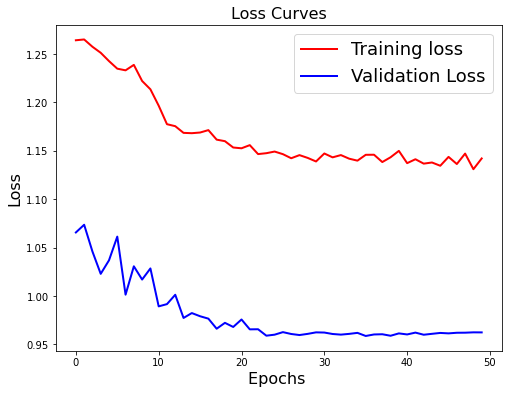

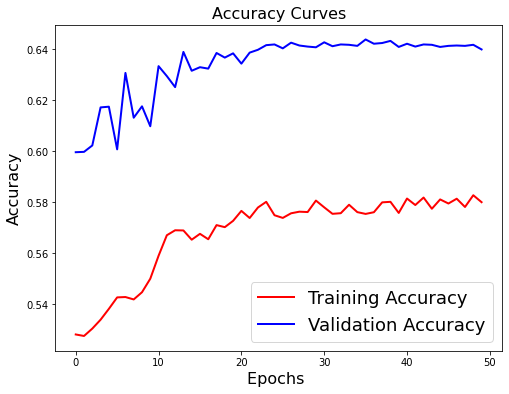

In [33]:
#Plotting accuracy and loss curves for model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [66]:
from sklearn.metrics import classification_report

y_pred = model.predict(validation_generator)
predictions = np.argmax(y_pred, axis=1)
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.53      0.61      0.57       958
           1       0.00      0.00      0.00       111
           2       0.51      0.30      0.37      1024
           3       0.89      0.87      0.88      1774
           4       0.53      0.74      0.61      1233
           5       0.53      0.51      0.52      1247
           6       0.76      0.75      0.76       831

    accuracy                           0.64      7178
   macro avg       0.53      0.54      0.53      7178
weighted avg       0.63      0.64      0.63      7178



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
result = classification_report(labels, predictions, output_dict=True)
result['0'].keys()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


dict_keys(['precision', 'recall', 'f1-score', 'support'])

In [43]:
predictions = np.argmax(y_pred, axis=1)

predictions

array([2, 3, 2, ..., 3, 2, 6])

In [62]:
labels = []
for res in validation_generator:
    batch_labels = np.argmax(res[1], axis=1)
    labels.extend(batch_labels)
    if len(batch_labels) < batch_size:
        break

In [64]:
len(labels)

7178

In [60]:
len(lables)

0